# Classification with scikit-learn and Sagemaker

## Model training and evaluation

### Model selection

I explored three models:
* A Naive Bayes classifier using features from the `reviews_body` field. This model uses only 1-grams.
* A Naive Bayes classifier using features from the `product_titles` field. This model also uses only 1-grams.
* A second Naive Bayes classifier using features from the `product_titles` field, but this time using all 1-, 2- and 3-grams contained in each title as features.

A Naive Bayes classifier trained on text is a model that calculates the likelihood of a piece of text belonging to a category based on the presence of a term in that piece of text. The "naive" in the title comes from the assumption that the presence of a term in a piece of text is independent of all of the other terms in that text, which is obviously rarely true in practice, including in the case of my training data. 

However, even when this assumption is violated, Naive Bayes models tend to perform well at category prediction, as well as being extremely fast to train and predict. They also work well with high-dimension data such as words. As such, I decided to use a Naive Bayes for this proof-of-concept in order to get a sense of what signal was present in the text fields available for training before moving onto more sophisticated models.

### Model training and deployment

In order to train the models, I set up a SageMaker session, and used this to upload the training data from my notebook instance to the model instance. I then ran the training script specific to that model. Finally, after the model was trained, I deployed each model to an endpoint, ready for prediction.

Within each training script, there are two final data cleaning steps. Firstly, I needed to vectorise the text data (that is, convert each piece of text into a vector, with each index of the vector representing the presence of items in the corpus vocabulary). Instead of using a simple count of words in the vocabulary, I decided to use the tf-idf (term frequency–inverse document frequency), which is a ratio of how important a word is in a document compared to how common it is in the corpus. It tends to give much more information about the relative importance of a term to a piece of text's meaning than a simple count.

Secondly, I converted the text labels of the target `product_categories` into numeric labels, as this is the format required to train the model.

In [1]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from time import sleep
from ipywidgets import IntProgress
from IPython.display import display

sagemaker_session = sagemaker.Session()
role = get_execution_role()

# Upload the data
TRAIN_DATA = "data"
training_data_id = sagemaker_session.upload_data(TRAIN_DATA)

In [2]:
# Create the model object for the reviews data
sklearn_reviews = SKLearn(
    entry_point="scikit_learn_nb_reviews.py",
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
)

# Train reviews model
sklearn_reviews.fit({"train": training_data_id})

2019-11-07 17:58:02 Starting - Starting the training job...
2019-11-07 17:58:03 Starting - Launching requested ML instances...
2019-11-07 17:59:00 Starting - Preparing the instances for training......
2019-11-07 17:59:52 Downloading - Downloading input data...
2019-11-07 18:00:24 Training - Training image download completed. Training in progress..2019-11-07 18:00:25,262 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-11-07 18:00:25,264 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-11-07 18:00:25,274 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-11-07 18:00:25,525 sagemaker-containers INFO     Module scikit_learn_nb_reviews does not provide a setup.py. 
Generating setup.py
2019-11-07 18:00:25,525 sagemaker-containers INFO     Generating setup.cfg
2019-11-07 18:00:25,526 sagemaker-containers INFO     Generating MANIFEST.in
2019-11-07 18:00:25,526 sagemaker-containers INFO   

In [3]:
# Deploy reviews model to endpoint
predictor_reviews = sklearn_reviews.deploy(
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge"
)

--------------------------------------------------------------------------------------------------!

In [4]:
# Create the model object for the titles data
sklearn_titles = SKLearn(
    entry_point="scikit_learn_nb_titles.py",
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session
)

# Train titles model
sklearn_titles.fit({"train": training_data_id})

2019-11-07 18:16:39 Starting - Starting the training job...............
2019-11-07 18:18:45 Starting - Launching requested ML instances.........
2019-11-07 18:20:11 Starting - Preparing the instances for training...
2019-11-07 18:21:04 Downloading - Downloading input data...
2019-11-07 18:21:32 Training - Downloading the training image..2019-11-07 18:21:45,408 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-11-07 18:21:45,411 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-11-07 18:21:45,421 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-11-07 18:21:45,686 sagemaker-containers INFO     Module scikit_learn_nb_titles does not provide a setup.py. 
Generating setup.py
2019-11-07 18:21:45,686 sagemaker-containers INFO     Generating setup.cfg
2019-11-07 18:21:45,686 sagemaker-containers INFO     Generating MANIFEST.in
2019-11-07 18:21:45,686 sagemaker-containers INFO     Installin

In [5]:
# Deploy titles model to endpoint
predictor_titles = sklearn_titles.deploy(
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge"
)

--------------------------------------------------------------------------------------!

In [6]:
# Create the model object for the titles 1-3-grams data
sklearn_titles_n_grams = SKLearn(
    entry_point="scikit_learn_nb_titles_n_grams.py",
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session
)

# Train titles 1-3-grams model
sklearn_titles_n_grams.fit({"train": training_data_id})

2019-11-07 18:32:42 Starting - Starting the training job...
2019-11-07 18:32:44 Starting - Launching requested ML instances......
2019-11-07 18:33:43 Starting - Preparing the instances for training...
2019-11-07 18:34:36 Downloading - Downloading input data...
2019-11-07 18:35:09 Training - Training image download completed. Training in progress..2019-11-07 18:35:10,243 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-11-07 18:35:10,245 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-11-07 18:35:10,255 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-11-07 18:35:10,552 sagemaker-containers INFO     Module scikit_learn_nb_titles_n_grams does not provide a setup.py. 
Generating setup.py
2019-11-07 18:35:10,553 sagemaker-containers INFO     Generating setup.cfg
2019-11-07 18:35:10,553 sagemaker-containers INFO     Generating MANIFEST.in
2019-11-07 18:35:10,553 sagemaker-containers 

In [7]:
# Deploy titles 1-3-grams model to endpoint
predictor_titles_n_grams = sklearn_titles_n_grams.deploy(
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge"
)

--------------------------------------------------------------------------------------!

### Generating model predictions

Following the model training and deployment, I then ran the test sets appropriate to each feature set through the prediction endpoints. Prior to prediction, I again vectorised the features in the test set using the tf-idf. I ended up with 3 test datasets, one for each of the models.

In [8]:
def generate_predictions(
    start_index: int,
    finish_index: int,
    data_x: "pandas.DataFrame",
    data_y: "pandas.DataFrame",
    predictor: "sagemaker.sklearn.model.SKLearnPredictor",
    vectoriser: "sklearn.feature_extraction.text.TfidfVectorizer",
) -> "pandas.DataFrame":
    """
    This function gets predictions based on a specified (test or validation) dataset from a 
    chosen prediction endpoint, and merges them into a DataFrame with the actual values from that 
    dataset.
    """

    data_x_tfidf = vectoriser.transform(
        data_x[start_index:finish_index].apply(lambda x: np.str_(x))
    )

    preds = predictor.predict(data_x_tfidf.toarray())

    preds_processed = pd.DataFrame(preds)
    preds_processed = preds_processed.set_index(np.arange(start_index, finish_index, 1))

    # Extract actual values from test data
    comparison = pd.concat([data_y[start_index:finish_index], preds_processed], axis=1)
    comparison.columns = ["actual_text", "predicted_numeric"]

    return comparison

In [10]:
@pd.api.extensions.register_dataframe_accessor("ml")
class PandasML:
    def __init__(self, data: "pandas.DataFrame"):
        self.data = data

    def train_vectoriser(
        self, max_ngrams: int = 1
    ) -> "sklearn.feature_extraction.text.TfidfVectorizer":
        """
        Returns a model from a Pandas DataFrame
        """

        # Train vectoriser on full data set
        tfidf_vect = TfidfVectorizer(max_features=5000, ngram_range=(1, max_ngrams))
        tfidf_vect.fit(self.data.iloc[:, 0].apply(lambda x: np.str_(x)))

        return tfidf_vect

    def merge_predictions(
        self,
        predictor: "sagemaker.sklearn.model.SKLearnPredictor",
        vectoriser: "sklearn.feature_extraction.text.TfidfVectorizer",
    ) -> "pandas.DataFrame":

        """
        Generates the predictions given a test or validation dataset and a deployed model object,
        merges these predictions with the actual values, and generates a column indicating whether
        a predicted category equals the actual category.
        """

        # Create prediction input
        test_x = self.data.iloc[:, 0].apply(lambda x: np.str_(x))
        test_y = self.data["product_category"].apply(lambda x: np.str_(x))

        # Get the length of the DataFrame and set up the progress bar for iteration
        top = int(math.floor(len(self.data) / 100.0)) * 100
        progress = IntProgress(min=0, max=top, description="Predicting:")
        display(progress)

        # NOTE: We process 100 elements at a time
        comparison_data = generate_predictions(
            0, 100, test_x, test_y, predictor, vectoriser
        )
        progress.value += 100
        for i in np.arange(100, top, 100):
            progress.value += 100
            sleep(0.1)
            predictions = generate_predictions(
                i, i + 100, test_x, test_y, predictor, vectoriser
            )
            comparison_data = comparison_data.append(predictions)

        # Clean the data by creating a text and numeric version each of the actual and predicted target
        categories_to_numeric = {
            "Digital_Software": 0,
            "Digital_Video_Games": 1,
            "Software": 2,
        }
        categories_to_text = {
            0: "Digital_Software",
            1: "Digital_Video_Games",
            2: "Software",
        }

        comparison_data["predicted_text"] = comparison_data["predicted_numeric"].map(
            categories_to_text
        )
        comparison_data["actual_numeric"] = comparison_data["actual_text"].map(
            categories_to_numeric
        )

        comparison_data["correct"] = np.where(
            comparison_data["actual_numeric"] == comparison_data["predicted_numeric"],
            1,
            0,
        )

        return comparison_data

In [11]:
%%time

# Reviews test
full_review = pd.read_csv("data/full_reviews.csv")
tfidf_reviews = full_review.ml.train_vectoriser()

test_review = pd.read_csv("data/test_reviews.csv")
test_comparison_reviews = test_review.ml.merge_predictions(
    predictor_reviews, tfidf_reviews
)

# Titles test
full_titles = pd.read_csv("data/full_titles.csv")
tfidf_titles = full_titles.ml.train_vectoriser()
tfidf_titles_n_grams = full_titles.ml.train_vectoriser(3)

test_titles = pd.read_csv("data/test_titles.csv")
test_comparison_titles = test_titles.ml.merge_predictions(
    predictor_titles, tfidf_titles
)
test_comparison_titles_n_grams = test_titles.ml.merge_predictions(
    predictor_titles_n_grams, tfidf_titles_n_grams
)

IntProgress(value=0, description='Predicting:', max=59900)

IntProgress(value=0, description='Predicting:', max=60000)

IntProgress(value=0, description='Predicting:', max=60000)

CPU times: user 1min 11s, sys: 2.45 s, total: 1min 14s
Wall time: 8min 13s


## Assessing model accuracy

Now that the models were trained, deployed and the predictions were run against the test datasets, I was then able to calculate the accuracy of each model. Starting with the model trained with `review_body` tokens as the features, I got an accuracy of 73.12%:

In [12]:
round(test_comparison_reviews["correct"].sum() / len(test_comparison_reviews) * 100, 2)

73.12

I then looked at the model trained with `product_title` tokens as the features, and got a much better accuracy of 85.45%.

In [13]:
round(test_comparison_titles["correct"].sum() / len(test_comparison_titles) * 100, 2)

85.45

Finally, I then examined whether the addition of all 2- and 3-grams to the `product_title` features helped improve the accuracy of the model:

In [14]:
round(test_comparison_titles_n_grams["correct"].sum() / len(test_comparison_titles_n_grams) * 100, 2)

85.14

As the addition of the 2- and 3-grams did not improve model accuracy in the test set, I decided to select the second model (the one using the `product_title` tokens) as the final one for this proof-of-concept.

I confirmed that this model was able to achieve a similar level of accuracy on the validation dataset. Given that this was the case, I moved onto evaluating the model's strengths and limitations.

In [15]:
# Titles validation
val_titles = pd.read_csv('data/val_titles.csv')
val_comparison_titles = val_titles.ml.merge_predictions(predictor_titles, tfidf_titles)

round(val_comparison_titles["correct"].sum() / len(val_comparison_titles) * 100, 2)

IntProgress(value=0, description='Predicting:', max=59900)

85.17

### Evaluating model strengths and limitations

Finally, I wanted to assess where the model was performing well, where it was limited, and assess possible ways to improve the model accuracy.

To start, I created a confusion matrix to assess which categories the model was able to predict well and where it tended to be weaker.

In [21]:
def print_confusion_matrix(
    confusion_matrix: "numpy.ndarray",
    class_names: list,
    normalize: bool = False,
    figsize: tuple = (10, 7),
    fontsize: int = 14,
):

    """
    Reads in an sklearn confusion matrix and returns a plot. Code taken from: 
    https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    """

    if normalize:
        confusion_matrix = (
            confusion_matrix.astype("float")
            / confusion_matrix.sum(axis=1)[:, np.newaxis]
        )
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(
            df_cm, cmap="RdBu", annot=True, fmt=".2f" if normalize else "d"
        )
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=fontsize
    )
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=fontsize
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Normalized confusion matrix


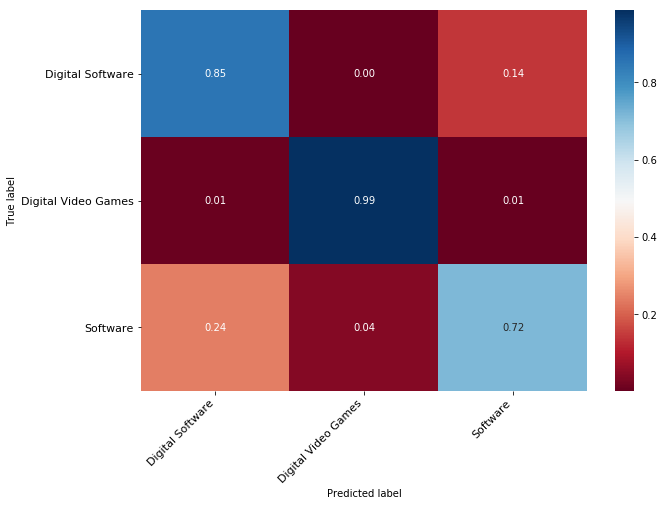

In [22]:
y_true = val_comparison_titles["actual_numeric"].tolist()
y_pred = val_comparison_titles["predicted_numeric"].tolist()
titles_cm = confusion_matrix(y_true, y_pred)
print_confusion_matrix(
    titles_cm,
    ["Digital Software", "Digital Video Games", "Software"],
    normalize=True,
    fontsize=11,
)

As can be seen, the model is extremely strong at predicting the Digital Video Games category, with an accuracy of 99%. However, the model is much weaker at accurately predicting the Software category, with a much lower accuracy of 72%. The model most often misclassifies Software products as Digital Software products, and vice versa, which is unsurprising given the likely similarity of the product titles for digital- and non-digital software products. 

In order to further explore why the model is misclassifying Software and Digital Software products, I examined the titles of a sample of properly classified vs misclassified Digital Software and Software products.

In [23]:
soft_to_dig_soft = val_comparison_titles[
    (val_comparison_titles["actual_text"] == "Software")
    & (val_comparison_titles["predicted_text"] == "Digital_Software")
][:5].index

dig_soft_to_soft = val_comparison_titles[
    (val_comparison_titles["actual_text"] == "Digital_Software")
    & (val_comparison_titles["predicted_text"] == "Software")
][:5].index

soft_to_soft = val_comparison_titles[
    (val_comparison_titles["actual_text"] == "Software")
    & (val_comparison_titles["predicted_text"] == "Software")
][:5].index

dig_soft_to_dig_soft = val_comparison_titles[
    (val_comparison_titles["actual_text"] == "Digital_Software")
    & (val_comparison_titles["predicted_text"] == "Digital_Software")
][:5].index

In [24]:
# Predicted Digital Software when the actual category was Software
val_titles.loc[soft_to_dig_soft]

,product_title,product_category
10,turbo tax parent v,Software
13,turbo tax parent v,Software
37,turbotax premier fed efile state,Software
46,mcafee antivirus plus pc,Software
63,turbo tax parent v,Software


In [25]:
# Predicted Software when the actual category was Digital Software
val_titles.loc[dig_soft_to_soft]

,product_title,product_category
45,adobe photoshop lightroom,Digital_Software
82,microsoft visio standard pc user,Digital_Software
115,music maker,Digital_Software
121,power pdf standard english,Digital_Software
129,adobe illustrator cs,Digital_Software


In [26]:
# Correctly predicted Software category
val_titles.loc[soft_to_soft]

,product_title,product_category
3,microsoft windows xp home edition version,Software
9,iolo system mechanic professional pcs,Software
11,family tree maker essentials old version,Software
14,instant immersion spanish platinum,Software
15,ubuntu linux special edition dvd includes bit ...,Software


In [27]:
# Correctly predicted Digital Software category
val_titles.loc[dig_soft_to_dig_soft]

,product_title,product_category
0,avast free antivirus download,Digital_Software
1,mavis beacon keyboarding kidz,Digital_Software
4,avast free antivirus download,Digital_Software
8,quicken home business,Digital_Software
16,turbotax premier federal e file state old version,Digital_Software


From this brief look into the features that allowed the correct classification of Software, terms such as "dvd" or "old version" likely allowed the identification of physical copies of software. On the other hand, terms that allowed the correct classification of Digital Software products likely include terms such as "efile" or "download". It is difficult to see with the misclassified products which features mark them as digital or physical, making it likely that the algorithm did not have enough information to make the correct decision in these cases.

### Further developing this model

The current solution is quite simple, but does already have an accuracy of 86%. Depending on the manual misclassification rate, this may already be an improvement; however, there are quite a few options that could improve the accuracy of this model.

#### Feature development
As it is clear that the features that describe Software and Digital Software products are very similar, the simplest solution to improve the model accuracy could be to use additional or different features for the model, such as the seller of the product.

#### Text cleaning
There are additional text cleaning steps we could take that would further reduce the noise in our model. I could use lemmatisation in order to combine all grammatical variants of the same word, which would consolidate the signal from that feature.

In addition, given that the greedy creation of n-grams used in the tf-idf tokeniser failed to improve the model accuracy, I could try a more selective approach. One possible idea would be to use past queries to identify meaningful n-grams.

#### Models
As the model that I used was quite unsophisticated, we could attempt to improve accuracy using a more complicated model. One alternative to Naive Bayes is Support Vector Machines, which have a better ability than Naive Bayes classifiers to tell apart closely related categories.

#### Improve training set
One assumption I made when training this model is that there are no misclassified products in the training data. However, this may not be the case, and it could be worth investigating whether there are any errors in the training data. If so, I could build a more robust training set using manual classification through SageMaker Ground Truth.
    
#### Further considerations
We should make sure that the model also has improved accuracy when all categories are used, rather than just the three used for this proof-of-concept.

We should also think about how we would like to implement this solution. It would be preferrable to correctly classify products before they even go on sale on the site; therefore, I suggest that we could use the pipeline in a category autosuggest when sellers create the page to sell their product. Implementing the pipeline in this manner means that we would need to ensure that the model can continue to return predictions quickly, as well as only use features available at the time the product page is being created.

Finally, we should consider whether this solution needs to be implemented outside of the US market. For example, a predictor based on English-language text will not work in a non-English-speaking market. As such, we should either look at features that will be consistent across different Amazon brands, or think about developing different categorisation algorithms for each different market.